In [1]:
import os
import sys

if len(sys.argv) > 1:
    visible_device = str(sys.argv[1])
else:
    visible_device = 1
    # controls on which gpu the program runs
os.environ['CUDA_VISIBLE_DEVICES'] = str(visible_device)

In [2]:
from pathlib import Path
from functools import partial

import numpy as onp

import matplotlib.pyplot as plt

import optax

import haiku as hk

from jax import numpy as jnp, random

from jax_md import space, energy, partition, simulate

In [3]:
from chemtrain.jax_md_mod import io, custom_space, custom_energy
from chemtrain import trainers, traj_util, util, quantity
from chemtrain.potential import neural_networks, layers

# DiffTRe: CG Water on Structural Data

In [ ]:
checkpoint = '../../examples/water/simulations/cg_water_example.pkl'

## Setup Training


### System

In [10]:
system = {}

file = '../../examples/water/data/confs/Water_experimental_3nm.gro'

box, r_init, _, _ = io.load_box(file)  # initial configuration
mass = 18.0154

box_tensor, scale_fn = custom_space.init_fractional_coordinates(box)
displacement_fn, shift_fn = space.periodic_general(box_tensor, fractional=True, wrapped=True)
r_init = scale_fn(r_init)

neighbor_fn = partition.neighbor_list(
    displacement_fn, box, r_cutoff=0.5, disable_cell_list=True)
nbrs_init = neighbor_fn.allocate(r_init)

system.update({
    "displacement_fn": displacement_fn,
    "reference_box": box,
    "reference_box_tensor": box_tensor,
    "nbrs_init": nbrs_init,
    "r_init": r_init
})

### Model

In [11]:
mlp_init = {
    'b_init': hk.initializers.Constant(0.),
    'w_init': layers.OrthogonalVarianceScalingInit(scale=1.)
    }

model_init, model_apply = neural_networks.dimenetpp_neighborlist(
    displacement_fn, r_cutoff=0.5, n_species=1, positions_test=r_init,
    neighbor_test=nbrs_init)

prior_energy_apply = custom_energy.generic_repulsion_neighborlist(
    displacement_fn, box, sigma=0.3165, epsilon=1.0, exp=12.0,
    r_onset=0.45, r_cutoff=0.5, initialize_neighbor_list=False)

def energy_fn_template(energy_params):
    def energy_fn(pos, neighbor, **dyn_kwargs):
        gnn_energy = model_apply(energy_params, pos, neighbor, **dyn_kwargs)

        prior_energy = prior_energy_apply(pos, neighbor, **dyn_kwargs)

        return prior_energy + gnn_energy

    return energy_fn

init_model_params = model_init(random.PRNGKey(0), r_init, nbrs_init)

Capping edges and triplets. Beware of overflow, which is currently not being detected.


/usr/local/Caskroom/miniconda/base/envs/MA/lib/python3.8/site-packages/jax/_src/numpy/lax_numpy.py:173: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)
/usr/local/Caskroom/miniconda/base/envs/MA/lib/python3.8/site-packages/jax/_src/numpy/reductions.py:206: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in sum is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return _reduction(a, "sum", np.sum, lax.add, 0, preproc=_cast_to_numeric,


### Optimizer

In [ ]:
check_freq = 10
num_updates = 2

initial_lr = -0.003  # in npt ensemble no more than 0.002; maybe even 0.001

lr_schedule = optax.exponential_decay(initial_lr, num_updates, 0.01)
optimizer = optax.chain(
    optax.scale_by_adam(0.1, 0.4),
    optax.scale_by_schedule(lr_schedule)
)

### Simulator

In [ ]:
system_temperature = 296.15  # Kelvin
boltzmann_constant = 0.0083145107  # in kJ / mol K
kbt = system_temperature * boltzmann_constant

time_step = 0.01
total_time = 70.
t_equilib = 10.
print_every = 0.1

timings = traj_util.process_printouts(time_step, total_time, t_equilib,
                                      print_every)

In [ ]:
simulator_template = partial(
    simulate.nvt_nose_hoover, shift_fn=shift_fn,
    dt=time_step, kT=kbt, mass=mass)


simulator_init, _ = simulator_template(
    energy_fn_template(init_model_params)
)

init_simulator_state = simulator_init(random.PRNGKey(0), r_init, neighbor=nbrs_init)
reference_simulation_state = (init_simulator_state, nbrs_init)

### Targets

In [7]:
reference_rdf = onp.loadtxt("../../examples/water/data/experimental/O_O_RDF.csv")
reference_adf = onp.loadtxt("../../examples/water/data/experimental/O_O_O_ADF.csv")
pressure_target = 1. / 16.6054   # 1 bar in kJ / mol nm^3

In [12]:
target_builder = quantity.TargetBuilder()

target_builder["rdf"] = quantity.structure.init_radial_distribution_target(
    reference_rdf, nbins=300, rdf_cut=1.0, gamma=1.0
)
target_builder["adf"] = quantity.structure.init_angular_distribution_target(
    reference_adf, nbins=150, r_outer=0.318, gamma=1.0
)
target_builder["pressure"] = quantity.thermodynamics.init_pressure_target(
    pressure_target, gamma=1.0e-7
)

targets, compute_fns = target_builder.build(system)

### Trainer

In [ ]:
trainer = trainers.Difftre(init_model_params,
                           optimizer,
                           energy_fn_template=energy_fn_template)

In [ ]:
trainer.add_statepoint(energy_fn_template, simulator_template,
                       neighbor_fn, timings, kbt, compute_fns, reference_simulation_state,
                       targets, pressure_target)

In [ ]:
trainer.init_step_size_adaption(0.25)

## Train

In [ ]:
if checkpoint is not None:  # restart from a previous checkpoint
    trainer = util.load_trainer(checkpoint)

In [ ]:
if recompute:
    trainer.train(num_updates, checkpoint_freq=None)
    trainer.save_trainer("../../examples/water/simulations/cg_water_example.pkl", ".pkl")

## Results

In [27]:
results = onp.load("../../examples/water/simulations/cg_water_example.pkl", allow_pickle=True)

predicted_quantities = results["predictions"][0]
loss_history = results["epoch_losses"]
num_updates = list(predicted_quantities.keys())[-1]

### Loss History

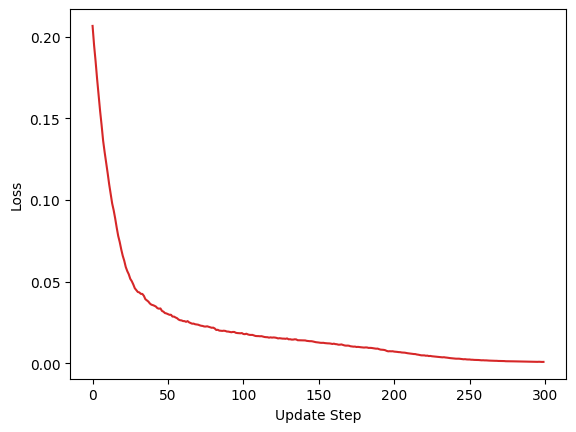

In [5]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Update Step')
ax1.set_ylabel('Loss')
ax1.plot(loss_history, color=color, label='Loss')

### RDF

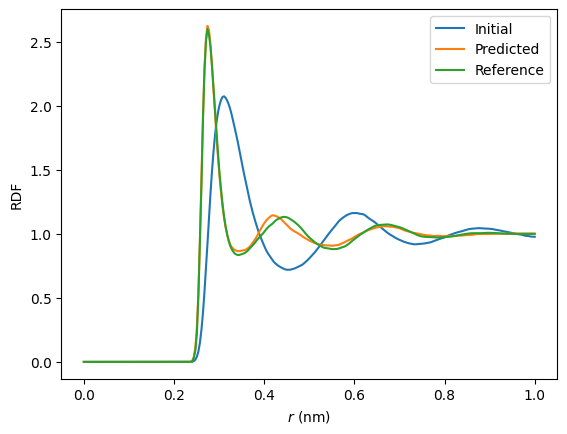

In [17]:
plt.figure()
plt.plot(predicted_quantities[0]["rdf"], label='Initial')
plt.plot(predicted_quantities[num_updates]["rdf"], label='Predicted')
plt.plot(targets["rdf"]["target"], label='Reference')
plt.legend()

### ADF

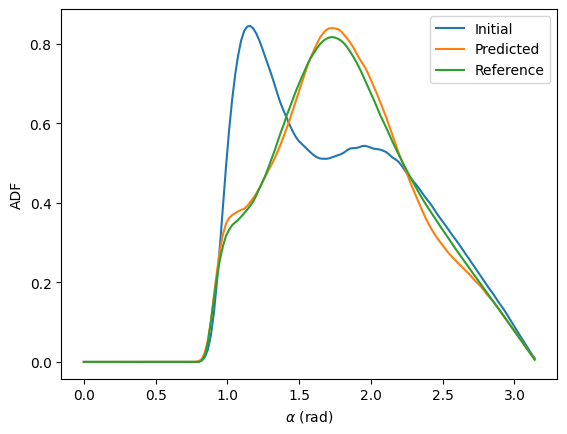

In [20]:
plt.figure()
plt.plot(predicted_quantities[0]["adf"], label='Initial')
plt.plot(predicted_quantities[num_updates]["adf"], label='Predicted')
plt.plot(targets["adf"]["target"], label='Reference')
plt.legend()

### Pressure

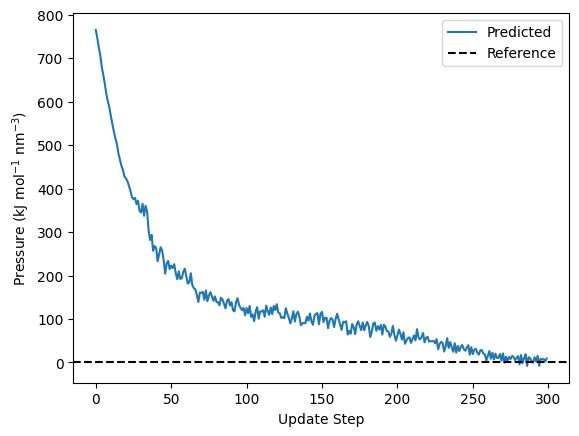

In [24]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Update Step')
ax1.set_ylabel('Pressure in kJ/ (mol nm^3)')
ax1.plot([preds["pressure"] for preds in predicted_quantities.values()], label='Predicted')
ax1.axhline(y=pressure_target, linestyle='--', label='Reference', color='k')
ax1.legend()